In [17]:
import os
import time
import sys

os.environ['MKL_NUM_THREADS'] = '2'
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['GOTO_NUM_THREADS'] = '2'

import numpy as np
import pylab as plt
import matplotlib as mpl
from scipy import stats

import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
from scipy.signal import savgol_filter

sys.path.append('/media/bigdata/firing_space_plot/ephys_data/')
import visualize as vz

from sklearn.decomposition import PCA

## Generate synthetic data

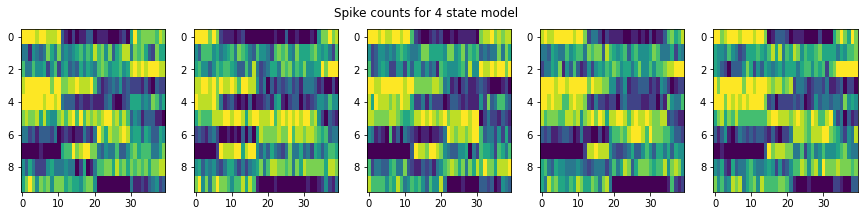

In [18]:
# Some poisson spiking
length = 400
bin_width = 10
states = 4
nrns = 10
tastes = 4
trials = 30
idx = np.arange(length)

#true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau = np.cumsum(np.random.uniform(2,30, size = (tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,3))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

In [19]:
################
# Generate shuffled data
# Spike array : tastes x trials x neurons x timebins
inds = list(np.ndindex((data_array.shape[0], *data_array.shape[2:])))
shuffle_data = np.zeros(data_array.shape)

for this_ind in inds:
    shuffle_data[this_ind[0],:,this_ind[1], this_ind[2]] = np.random.permutation(data_array[this_ind[0],:,this_ind[1], this_ind[2]])

# Also add a jitter of 50 to each spike
spike_times = np.where(shuffle_data)
jittered_spike_times = spike_times[3] + np.random.randint(-50,50, size = len(spike_times[3]))
jittered_spike_times[jittered_spike_times < 0] = 0 
jittered_spike_times[jittered_spike_times > length-1] = length-1
spike_times = (*spike_times[:3], jittered_spike_times)

shuffle_data = np.zeros(shuffle_data.shape)
shuffle_data[spike_times] = 1

shuffle_spikes = np.sum(shuffle_data.reshape((*shuffle_data.shape[:3],-1,bin_width)),axis=-1)
shuffle_spikes = np.vectorize(np.int)(shuffle_spikes) 

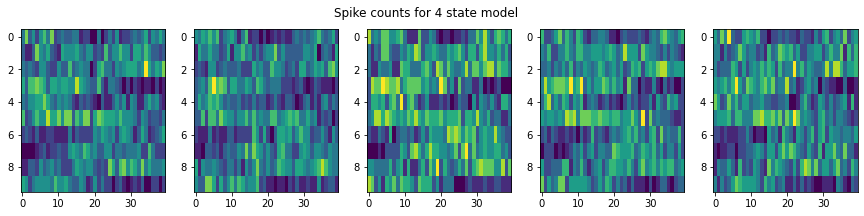

In [20]:
## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,3))
for plot_dat, this_ax in zip(shuffle_spikes[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


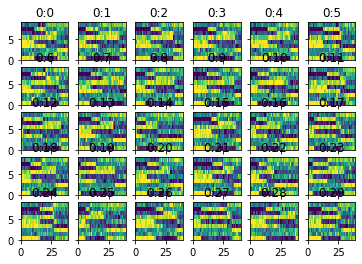

In [21]:
# Single neuron plots
taste_ind = 0
img_kwargs = dict(aspect='auto', interpolation='nearest')
vz.firing_overview(spike_array[taste_ind], cmap = 'viridis');

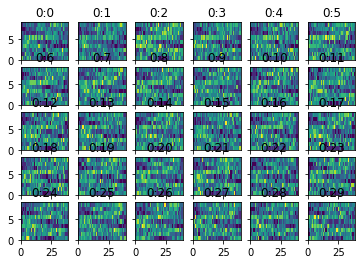

In [22]:
vz.firing_overview(shuffle_spikes[taste_ind], cmap = 'viridis');

In [26]:
trials = 5
data_list = [spike_array[taste_ind,:trials], shuffle_spikes[taste_ind,:trials]]
pca_rate = PCA(n_components = 4).fit_transform(data_list[0].mean(axis=0).T).T

In [27]:
n_components = pca_rate.shape[0]
x = np.arange(data_list[0].shape[-1])
with pm.Model() as gp_model:
    data = pm.Data('data', data_list[0])
       
    l = pm.Gamma("l", alpha=5, beta=1, testval = 0.5)
    eta = pm.Gamma("eta", alpha=0.7, beta=2)#pm.HalfCauchy("η", beta=0.1)
    # Specify the covariance function.
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = eta * pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Latent(cov_func=cov)
    
    factors = pm.Deterministic('factors',
                               tt.stack(
                        [
                            [
                        gp.prior(f"f{i}_{j}", X=x[:, None], testval = pca_rate[i]) \
                            for i in range(n_components)
                            ]
                            for j in range(trials)
                        ]
                    )
                              )
    
    
    factors_temp = tt.tile(factors[:,None,:,:], (1,nrns,1,1))
    proj_mat = pm.Normal('proj_mat', mu = 0, sigma = 0.4, shape = (nrns, n_components))
    proj_mat_temp = tt.tile(proj_mat[None,:,:,None], (trials,1,1,length//bin_width))
    
    lambda_latent = pm.Deterministic('lambda_latent', tt.sum(proj_mat_temp * factors_temp, axis=2))
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=data)

In [28]:
data_list[0].shape

(5, 10, 40)

In [29]:
with pm.Model() as changepoint_model:
    data = pm.Data('data', data_list[0])
    
    spike_array = data.get_value()

    mean_vals = np.array([np.mean(x, axis=-1)
                          for x in np.array_split(spike_array, states, axis=-1)]).T
    mean_vals = np.mean(mean_vals, axis=1)
    mean_vals += 0.01  # To avoid zero starting prob

    nrns = spike_array.shape[1]
    trials = spike_array.shape[0]
    idx = np.arange(spike_array.shape[-1])
    length = idx.max() + 1

    with pm.Model() as model:
        lambda_latent = pm.Exponential('lambda',
                                       1/mean_vals,
                                       shape=(nrns, states))

        a_tau = pm.HalfCauchy('a_tau', 3., shape=states - 1)
        b_tau = pm.HalfCauchy('b_tau', 3., shape=states - 1)

        even_switches = np.linspace(0, 1, states+1)[1:-1]
        tau_latent = pm.Beta('tau_latent', a_tau, b_tau,
                             testval=even_switches,
                             shape=(trials, states-1)).sort(axis=-1)

        tau = pm.Deterministic('tau',
                               idx.min() + (idx.max() - idx.min()) * tau_latent)

        weight_stack = tt.nnet.sigmoid(
                        idx[np.newaxis, :]-tau[:, :, np.newaxis])
        weight_stack = tt.concatenate(
                        [np.ones((trials, 1, length)), weight_stack], axis=1)
        inverse_stack = 1 - weight_stack[:, 1:]
        inverse_stack = tt.concatenate(
                        [inverse_stack, np.ones((trials, 1, length))], axis=1)
        weight_stack = np.multiply(weight_stack, inverse_stack)

        lambda_ = tt.tensordot(weight_stack, lambda_latent, [1, 1]).swapaxes(1, 2)
        observation = pm.Poisson("obs", lambda_, observed=data)

In [30]:
# print(data_list[0].shape)
# print(factors.tag.test_value.shape)
# print(factors_temp.tag.test_value.shape)
# print(model.proj_mat.tag.test_value.shape)
# print(proj_mat_temp.tag.test_value.shape)
# print(lambda_latent.tag.test_value.shape)

In [31]:
# vz.firing_overview(model.factors.tag.test_value, cmap = 'viridis');

In [32]:
# #pm.model_to_graphviz(gp_model)
# pm.model_to_graphviz(changepoint_model)

In [33]:
sharp_trace_list = []
for this_model in [gp_model, changepoint_model]:
    with this_model:
        pm.set_data({'data': data_list[0]})
        #trace = pm.sample(1000, chains=1, cores=1)#, step = pm.Metropolis())
        #trace_list.append(trace[::10])
    
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=160000, method=inference)
        trace = approx.sample(draws=2000)
        sharp_trace_list.append(trace)

Finished [100%]: Average Loss = 4,729.9
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 4,729.9


Finished [100%]: Average Loss = 3,848.5
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 3,848.5


In [39]:
# https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/model_comparison.html
df_comp_loo = az.compare({"gaussian_process": sharp_trace_list[0], "changepoint": sharp_trace_list[1]})
df_comp_loo

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likel

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
changepoint,0,-4925.572251,149.216601,0.000000,0.915039,55.380064,0.000000,False,log
gaussian_process,1,-5754.436995,1406.297726,828.864745,0.084961,79.651359,62.904919,True,log


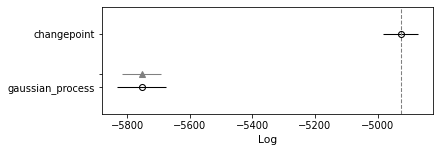

In [40]:
az.plot_compare(df_comp_loo, insample_dev=False);
fig = plt.gcf()
plt.savefig('sharp_comparison.png')

In [36]:
smooth_trace_list = []
for this_model in [gp_model, changepoint_model]:
    with this_model:
        pm.set_data({'data': data_list[1]})
        #trace = pm.sample(1000, chains=1, cores=1)#, step = pm.Metropolis())
        #trace_list.append(trace[::10])
    
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=160000, method=inference)
        trace = approx.sample(draws=2000)
        smooth_trace_list.append(trace)

Finished [100%]: Average Loss = 4,115.1
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 4,115.1


Finished [100%]: Average Loss = 3,825.9
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 3,825.9


In [41]:
# https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/model_comparison.html
df_comp_loo = az.compare({"gaussian_process": smooth_trace_list[0], "changepoint": smooth_trace_list[1]})
df_comp_loo

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likel

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
changepoint,0,-3741.065017,47.144521,0.000000,1.000000e+00,20.477068,0.000000,True,log
gaussian_process,1,-3961.259819,174.178913,220.194802,2.731149e-14,23.511729,12.901471,True,log


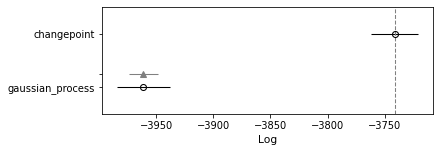

In [42]:
az.plot_compare(df_comp_loo, insample_dev=False);
fig = plt.gcf()
plt.savefig('smooth_comparison.png')

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likel

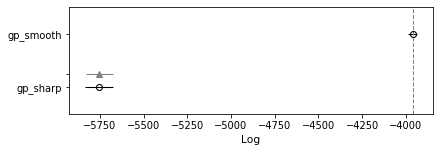

In [45]:
# Compare both for changepoint model
df_comp_loo = az.compare({"gp_sharp": sharp_trace_list[0], "gp_smooth": smooth_trace_list[0]})
#df_comp_loo
az.plot_compare(df_comp_loo, insample_dev=False);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/pytho

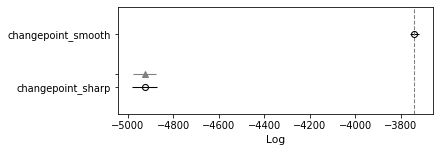

In [44]:
# Compare both for changepoint model
df_comp_loo = az.compare({"changepoint_sharp": sharp_trace_list[1], "changepoint_smooth": smooth_trace_list[1]})
#df_comp_loo
az.plot_compare(df_comp_loo, insample_dev=False);